# AOS LSSTCam CWFS Zernikes

Notebook Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: **8/22/2021** <br>
Verified Stack Release: **w_2021_32**

In [1]:
# Should match verified version above
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+6db7f69c27 	current w_2021_32 setup


## Notebook Goal
Demonstrate the processing of wave front images for LSSTCam Corner Wave Front Sensors (FAM) from raw to Zernikes.

## Installation

This notebook requires the LSST Science Pipelines as well as the following telescope and site packages: 
- `phosim_utils` (Only as a prerequisite for `ts_wep`. None of the code shown here uses it.) 
    - Tagged Version: `v0.2.7`
- `ts_wep`
    - Tagged Version: `v1.7.10`

### Installing `phosim_utils` and `ts_wep` on **Rubin Science Platform**

`phosim_utils` is available on GitHub [here](https://github.com/lsst-dm/phosim_utils) and `ts_wep` is available [here](https://github.com/lsst-ts/ts_wep). 

To install on **RSP** open a terminal in the notebook aspect: 
1. Set up the LSST Science Pipelines: 

```
source ${LOADSTACK}
setup lsst_distrib
```

2. Go to the directory you would like to install the packages and clone the `ts_phosim` and `ts_wep` repositories from the GitHub links above.
3. Inside the `phosim_utils` directory run the following to build the module:

```
setup -k -r .
scons
```

4. Repeat the same commands inside the `ts_wep` repository.
5. Add the following to your `${HOME}/notebooks/.user_setups` to run `ts_wep` in an **RSP** notebook:

```
setup -k -r {PATH_TO_PHOSIM_UTILS}
setup -k -r {PATH_TO_TS_WEP}
```
6. Restart notebook kernel and continue with the notebook.

## Data production

The phosim images used in this notebook were generated using `phosim_syseng4` with tag `v1.0.7`. They were repackaged using `phosim_utils` with tag `v0.2.7`. The command files and instance catalogs can be found in `/project/aos/phosim_output/wfsTestData_080221`.

## Run pipeline

### Pipeline Set Up

To run the full pipeline we can use the pipeline YAML file available for testing in `lsstCwfsPipeline.yaml` here in this directory. Here is what is in that file with comments:

In [2]:
! cat lsstCwfsPipeline.yaml

# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: Tr

### Run task from command line

Now we will run this pipeline using the `pipetask run` command available on the command line.

In [3]:
# Some basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This allows us to run command line tasks from inside the notebook easier
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, writeCleanUpRepoCmd

# Location of ts_wep
ts_wep_dir = os.environ['TS_WEP_DIR']

# Import Gen 3 Butler
from lsst.daf import butler as dafButler

#### Building our shell command

We need the following to specify our command:

In [4]:
# First specify the repository location
repoDir = '/project/aos/data_repos/lsstCwfs-w_2021_32/'
# Next we create a name for the output of our pipeline run
runName = 'cwfs_test'
# We are going to use comcam data so we specify the correct instrument
instrument = 'lsst.obs.lsst.LsstCam'
# Tell the pipeline which existing data in the repository to use
collections = 'refcats,LSSTCam/raw/all,LSSTCam/calib'
# And finally the file that specifies our pipeline tasks and configurations shown above
pipelineYaml = 'lsstCwfsPipeline.yaml'

Let's take a brief look inside our data repository by looking at the `butler.registry`

In [5]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

In [6]:
# What exposures are ingested already?
for dataId in registry.queryDataIds('exposure'):
    print(dataId)

{instrument: 'LSSTCam', exposure: 4021123106000, ...}


We see that there is a single `LSSTCam` exposure available. This is because we have both intra and extra-focal wavefront sensors available in a single exposure. Below we will still specify this exposure to show how to do it in case more data were to be added to this repository.

In [7]:
# Use the utility function in ts_wep to write our pipeline task command
runPipeTaskCmd = writePipetaskCmd(repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml)

In [8]:
# Add command to grab the specific exposure we want to use
runPipeTaskCmd += ' -d "exposure IN (4021123106000)"'

In [9]:
# # Add number of processors to use in parallel
runPipeTaskCmd += ' -j 2'

What does the full command look like?

In [10]:
print(runPipeTaskCmd)

pipetask run -b /project/aos/data_repos/lsstCwfs-w_2021_32/ -i refcats,LSSTCam/raw/all,LSSTCam/calib --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run cwfs_test -p lsstCwfsPipeline.yaml -d "exposure IN (4021123106000)" -j 2


In [11]:
# Run pipetask (This takes about 4 minutes to run inside the notebook on a medium RSP instance).
%time ! {runPipeTaskCmd}

ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 10 quanta for 3 tasks, graph ID: '1629673151.261441-2574'
conda.common.io INFO: overtaking stderr and stdout
conda.common.io INFO: stderr and stdout yielding back
isr INFO: Converting exposure to floating point values.
isr INFO: Converting exposure to floating point values.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Widening saturation trails.
isr INFO: Applying gain correction instead of flat.
isr INFO: Widening saturation trails.
isr INFO: Applying gain correction instead of flat.
isr WARNING: No rough magnitude zero point defined for filter g.
isr INFO: Setting rough magnitude zero point for filter g: 30.940228
isr WARNING: No rough magnitude zero point defined for filter g.
isr INFO: Setting rough magnitude zero point for filter g: 30.940228
ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 196, exposure: 4021123106000, ...

## Exploring Output

After our task runs we can now look at the new output saved in our data repository and accessible by the `butler`.

First, we need reload the butler to get the updated registry.

In [12]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

In [13]:
registry.getDatasetType('postISRCCD')

DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)

We can run `queryCollections` to see the available datasets and see that there is now a dataset called `cwfs_test` available.

In [14]:
for x in registry.queryCollections():
    print(x)

LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
refcats/gen2
refcats
LSSTCam/defaults
skymaps
cwfs_test


We can also look inside the registry to see the available dataset types. We have added `donutCatalog`, `donutStampsExtra`, `donutStampsIntra`, `zernikeEstimateRaw` and `zernikeEstimateAvg`.

In [15]:
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)

DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cal_ref_cat', {htm7}, SimpleCatalog)
DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('packages', {}, Packages)
DatasetType('estimateZernikesFamTask_config', {}, Config)
DatasetType('isr_config', {}, Config)
DatasetType('generateDonutCatalogOnlineTask_config', {}, Config)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('donutCatalog', {instrument}, DataFrame)
DatasetType('donutStampsExtra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('donutStampsIntra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('zernikeEstimateRaw', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('zernikeEstimateAvg', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('estimateZernikesFamTask_metadata',

To start exploring the new data products let's pick the `dataId` value for one extra-focal detector and another for an intra-focal detector from inside `cwfs_test` with an available `postISRCCD`. First we will see all the available `dataId` values listed.

In [16]:
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=[runName]))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTCam', detector: 196, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 191, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 204, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 203, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 199, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 200, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 195, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 192, exposure: 4021123106000, ...}


In [17]:
dataIdExtra = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 4021123106000}
dataIdIntra = {'instrument': 'LSSTCam', 'detector': 192, 'exposure': 4021123106000}

### Load postISR images

In [18]:
postIsrExpExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[runName])
postIsrExpIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[runName])

Text(0.5, 1.0, 'Donut Sources on R00_SW0. An extra-focal detector.')

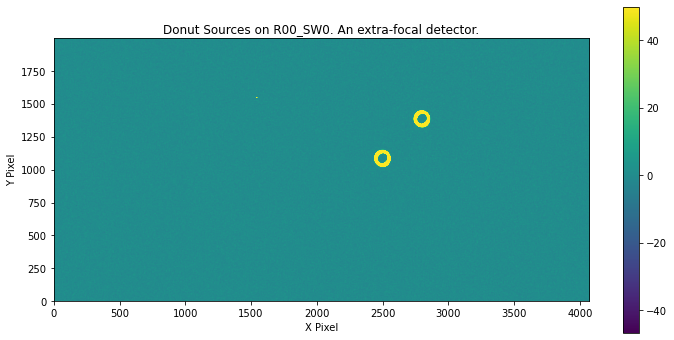

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
plt.imshow(postIsrExpExtra.image.array, origin='lower', vmax=50)
plt.colorbar()
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title(f'Donut Sources on {postIsrExpExtra.getDetector().getName()}. An extra-focal detector.')

Let's plot this with ra, dec coordinates. To do this we define the following function to make it easy.

In [20]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

def plotRaDec(postIsrExp):
    
    """
    Plot the image data and the WCS overlay.
    
    Parameters
    ----------
    postIsrExp : lsst.afw.image.Exposure
        The post-ISR exposure from the butler repository.
    """
    # Get the WCS for the projection
    wcs = postIsrExp.getWcs()
    header_dict = dict(wcs.getFitsMetadata())
    
    # Add in axis information
    header_dict['NAXIS'] = 2
    header_dict['NAXIS1'] = 4072
    header_dict['NAXIS2'] = 4000
    
    # Convert to astropy readable WCS
    astropyWcs = WCS(header_dict)
    
    # Grab image data and plot
    data = postIsrExp.getImage().getArray()
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    plt.subplot(projection=astropyWcs)#, slices=('y', 'x'))
    plt.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys',)

    # Format coordinates presentation
    ax = plt.gca()

    # Fix axis label issue (https://github.com/astropy/astropy/issues/7180)
    ax.coords[0].set_ticklabel_position('l')
    ax.coords[0].grid(color='yellow')
    ax.set_ylabel('RA')
    
    ax.coords[1].set_ticklabel_position('b')
    ax.coords[1].grid(color='yellow')
    ax.set_xlabel('Dec')

Text(0.5, 1.0, 'Donut Sources on R00_SW0. An extra-focal detector.')

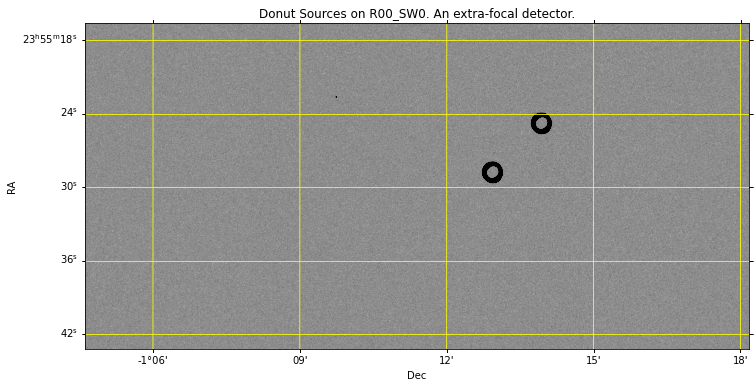

In [21]:
# plot the data and the WCS overlay 
fig = plt.figure(figsize=(12, 6))
plotRaDec(postIsrExpExtra)
plt.title(f'Donut Sources on {postIsrExpExtra.getDetector().getName()}. An extra-focal detector.')

Text(0.5, 1.0, 'Donut Sources on R00_SW1. An intra-focal detector.')

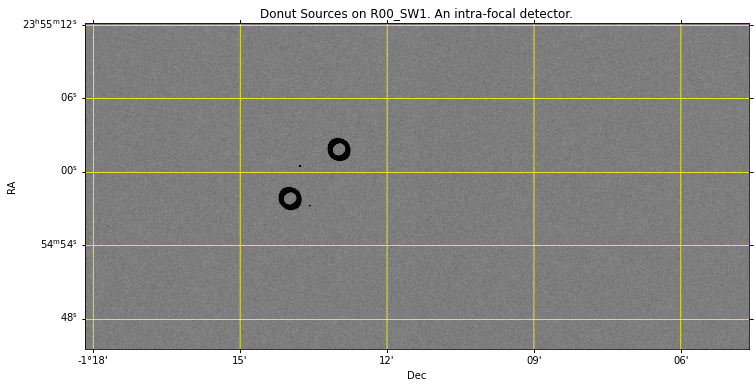

In [22]:
# plot the data and the WCS overlay 
fig = plt.figure(figsize=(12, 6))
plotRaDec(postIsrExpIntra)
plt.title(f'Donut Sources on {postIsrExpIntra.getDetector().getName()}. An intra-focal detector.')

### Load the donut catalog for an exposure

Let's load the `donutCatalog` and see all the sources from the reference catalog for an exposure.

In [23]:
srcCat = butler.get('donutCatalog', dataId=dataId, collections=[runName])

In [24]:
srcCat

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,detector
0,6.263161,-0.021515,2808.280340,1392.304678,3.630781e+06,R00_SW0
1,6.263451,-0.021225,2508.995466,1092.936386,3.630781e+06,R00_SW0
2,6.261221,-0.021513,1265.778880,932.130616,3.630781e+06,R00_SW1
3,6.261511,-0.021223,1565.016132,1231.397070,3.630781e+06,R00_SW1
4,6.261660,0.020026,2814.905466,1398.711774,3.630781e+06,R04_SW0
5,6.261950,0.019736,2515.446593,1099.399882,3.630781e+06,R04_SW0
6,6.261662,0.021960,1260.201510,930.916613,3.630781e+06,R04_SW1
7,6.261952,0.021670,1559.552308,1230.192906,3.630781e+06,R04_SW1
8,0.021516,-0.020037,2804.622704,1409.928441,3.630781e+06,R40_SW0
9,0.021226,-0.019747,2505.254000,1110.562477,3.630781e+06,R40_SW0


Let's make sure our `donutCatalog` is correct.

In [25]:
# expCatalog = srcCat.query(f'detector == "{exposureName}"')
expCatalog = srcCat.query(f'detector == "{postIsrExpExtra.getDetector().getName()}" or detector == "{postIsrExpIntra.getDetector().getName()}"')

Text(0.5, 1.0, 'Donut Sources on R00_SW0. An extra-focal detector.')

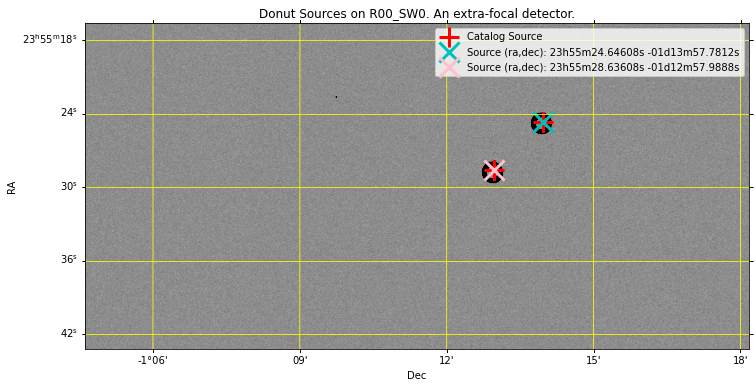

In [26]:
from astropy.coordinates import SkyCoord

fig = plt.figure(figsize=(12, 6))
plotRaDec(postIsrExpExtra)
plt.scatter(expCatalog['centroid_x'].iloc[:2], expCatalog['centroid_y'].iloc[:2], c='r', s=400, marker='+', lw=3, label='Catalog Source')
source_0 = SkyCoord(ra=expCatalog['coord_ra'].iloc[0] * u.rad, dec=expCatalog['coord_dec'].iloc[0] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[0], expCatalog['centroid_y'].iloc[0], marker='x', s=400, c='c', lw=3, 
            label=f"Source (ra,dec): {source_0.to_string('hmsdms')}")
source_1 = SkyCoord(ra=expCatalog['coord_ra'].iloc[1] * u.rad, dec=expCatalog['coord_dec'].iloc[1] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[1], expCatalog['centroid_y'].iloc[1], marker='x', s=400, c='pink', lw=3, 
            label=f"Source (ra,dec): {source_1.to_string('hmsdms')}")
plt.legend()
plt.title(f'Donut Sources on {postIsrExpExtra.getDetector().getName()}. An extra-focal detector.')

Extra-focal sources match the sources in the `donutCatalog`.

Text(0.5, 1.0, 'Donut Sources on R00_SW1. An intra-focal detector.')

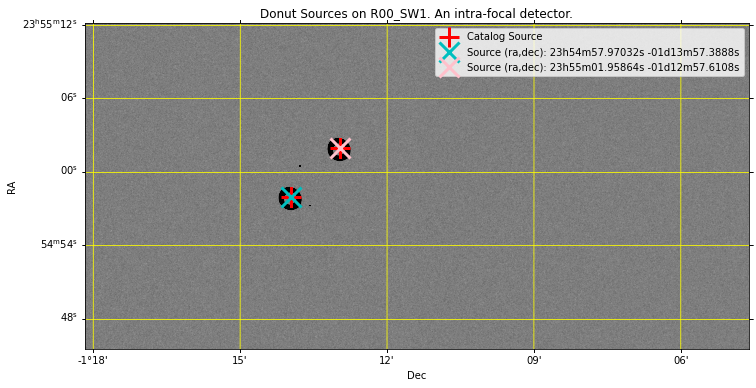

In [27]:
from astropy.coordinates import SkyCoord

fig = plt.figure(figsize=(12, 6))
plotRaDec(postIsrExpIntra)
plt.scatter(expCatalog['centroid_x'].iloc[2:], expCatalog['centroid_y'].iloc[2:], c='r', s=400, marker='+', lw=3, label='Catalog Source')
source_0 = SkyCoord(ra=expCatalog['coord_ra'].iloc[2] * u.rad, dec=expCatalog['coord_dec'].iloc[2] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[2], expCatalog['centroid_y'].iloc[2], marker='x', s=400, c='c', lw=3, 
            label=f"Source (ra,dec): {source_0.to_string('hmsdms')}")
source_1 = SkyCoord(ra=expCatalog['coord_ra'].iloc[3] * u.rad, dec=expCatalog['coord_dec'].iloc[3] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[3], expCatalog['centroid_y'].iloc[3], marker='x', s=400, c='pink', lw=3, 
            label=f"Source (ra,dec): {source_1.to_string('hmsdms')}")
plt.legend()
plt.title(f'Donut Sources on {postIsrExpIntra.getDetector().getName()}. An intra-focal detector.')

Intra-focal sources also match our `donutCatalog`.

Looks good. Our catalog sources lie on top of the donuts and our expected source coordinates from the `donutCatalog` match up the coordinates we get from the WCS of the image.

### Look at the `donutStamps`

In [28]:
extraFocalStamps = butler.get('donutStampsExtra', dataId=dataIdExtra, collections=[runName])
intraFocalStamps = butler.get('donutStampsIntra', dataId=dataIdIntra, collections=[runName])

The `donutStamps` objects contain the postage stamps as `lsst.afw.image.MaskedImage` objects along with extra metadata. Here we will load the image from one of the objects in each of the detectors shown above. Notice the `dataId` for the `extraFocalStamps` and the `intraFocalStamps` reference the appropriate detectors.

Text(0.5, 1.0, 'Intra-Focal Stamp')

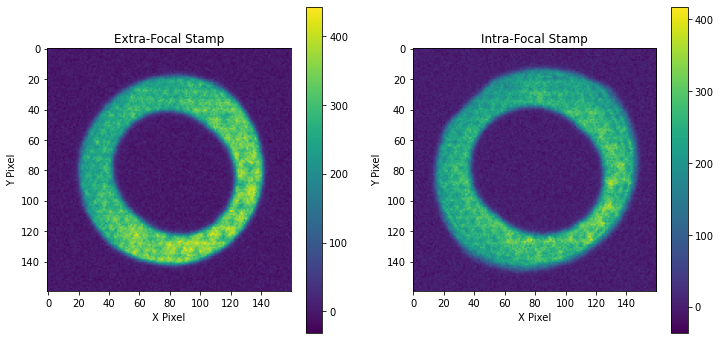

In [29]:
fig = plt.figure(figsize=(12, 6))

fig.add_subplot(1,2,1)
plt.imshow(extraFocalStamps[0].stamp_im.image.getArray())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar()
plt.title('Extra-Focal Stamp')

fig.add_subplot(1,2,2)
plt.imshow(intraFocalStamps[0].stamp_im.image.getArray())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar()
plt.title('Intra-Focal Stamp')

### Load the Zernike coefficients and compare to OPD

Here we have two sets of data associated with each pair of wavefront detectors. The `zernikeEstimateRaw` contains the Zernike coefficients estimated by the Wavefront Estimation Pipeline for each pair of donuts matched up on a pair of wavefront detectors. The `zernikeEstimateAvg` is the average estimate of the Zernike coefficients for each pair of wavefront detectors. The `dataId` associated with these outputs always reference the extra-focal chip so there are four available sets of data for each as shown below with each `dataId` containing the `detector` value of the extra-focal chip.

In [31]:
datasetRefs = list(registry.queryDatasets(datasetType='zernikeEstimateRaw', collections=[runName]))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTCam', detector: 191, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 195, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 199, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 203, exposure: 4021123106000, ...}


In [32]:
datasetRefs = list(registry.queryDatasets(datasetType='zernikeEstimateAvg', collections=[runName]))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTCam', detector: 191, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 195, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 199, exposure: 4021123106000, ...}
{instrument: 'LSSTCam', detector: 203, exposure: 4021123106000, ...}


In [34]:
extraDetectorIds = [191, 195, 199, 203]
zerCoeffList = []
for detectorNum in extraDetectorIds:
    zerDataId = {'instrument': 'LSSTCam', 'detector': detectorNum, 'exposure': 4021123106000}
    zerCoeffList.append(butler.get('zernikeEstimateAvg', dataId=zerDataId, collections=[runName]))

Each `zernikeEstimateAvg` output from the `butler` repository is a numpy array with the Zernike coeffecients as the values.

In [36]:
zerCoeffList[0]

array([-0.70976641,  0.86958692,  0.9504867 , -0.07292003, -0.01423537,
        0.00411627,  0.0634906 , -0.03639903, -0.05118631, -0.02256383,
        0.00891294, -0.01742325, -0.00548282,  0.00096307, -0.01825883,
        0.02692999,  0.02870871,  0.02485276, -0.00891392])

Let's compare these outputs to the OPD values for the center of the focal plane.

In [37]:
opdVals = np.genfromtxt('/project/aos/phosim_output/wfsTestData_080221/opd.zer')

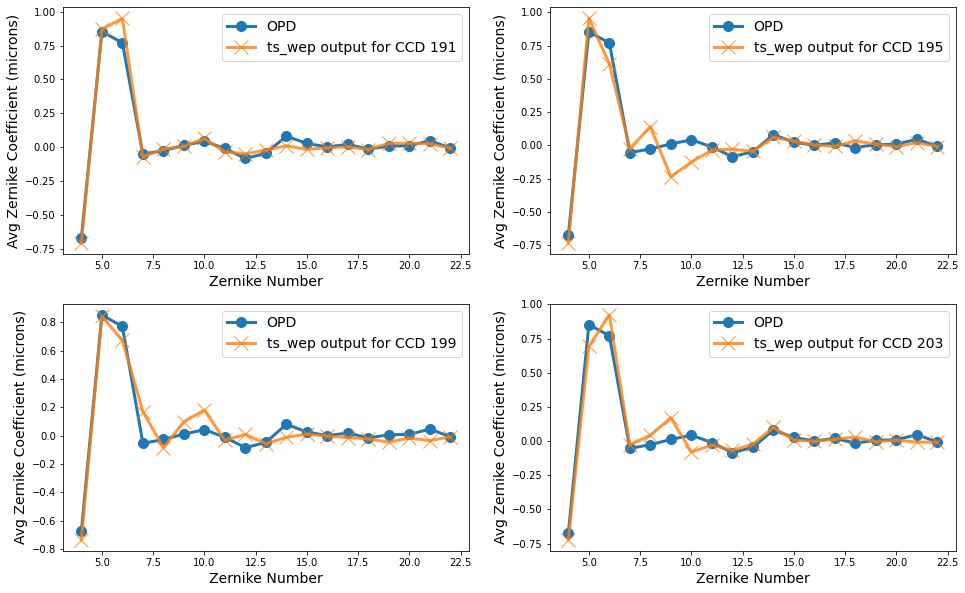

In [44]:
fig = plt.figure(figsize=(16, 10))

for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.plot(np.arange(4, 23), opdVals[85], '-o', lw=3, markersize=10, label='OPD')
    plt.plot(np.arange(4, 23), zerCoeffList[i], '-x', lw=3, markersize=14, 
             label=f'ts_wep output for CCD {extraDetectorIds[i]}', alpha=0.8)
    plt.xlabel('Zernike Number', size=14)
    plt.ylabel('Avg Zernike Coefficient (microns)', size=14)
    plt.legend(fontsize=14)

Looks like we are getting good agreement with the input Zernikes calculated using the OPD.

## Running pipeline tasks in-memory

When running these tasks it might be useful to speed things up by running the tasks without the I/O involved writing and getting data from the repository. Here we show how to run the tasks completely in memory.

### Create the donut catalog

First we still need to create a donut catalog that contains the information on sources in our pointing.

In [45]:
from lsst.ts.wep.task.GenerateDonutCatalogOnlineTask import GenerateDonutCatalogOnlineTask, GenerateDonutCatalogOnlineTaskConfig

#### Set configurations for the task

To set our configurations we will get boresight pointing information from the raw image as an example.

In [46]:
rawImage = butler.get('raw', dataId=dataIdExtra, collections=['LSSTCam/raw/all'])

In [47]:
rawImVisitInfo = rawImage.getInfo().getVisitInfo()
print(f"Boresight Ra, Dec is: {rawImVisitInfo.getBoresightRaDec()}, Boresight Rotation Angle in degrees is: {rawImVisitInfo.getBoresightRotAngle().asDegrees()}")

Boresight Ra, Dec is: (0.0000000000, +0.0000000000), Boresight Rotation Angle in degrees is: 90.0


We can now set up our configurations for our task.

In [48]:
donutCatConfig = GenerateDonutCatalogOnlineTaskConfig()
donutCatConfig.boresightRa = rawImVisitInfo.getBoresightRaDec().getRa().asDegrees()
donutCatConfig.boresightDec = rawImVisitInfo.getBoresightRaDec().getDec().asDegrees()
donutCatConfig.boresightRotAng = rawImVisitInfo.getBoresightRotAngle().asDegrees()

Then we feed this configuration information as we instantiate our task.

In [49]:
donutCatTask = GenerateDonutCatalogOnlineTask(config=donutCatConfig)

#### Prepare the data for the task

For our task we need to get the reference catalog available in the `Butler` repository. To do that we create a set of deferred pointers to the data so that they will only load into memory when we need them.

In [50]:
deferredList = []
datasetGenerator = registry.queryDatasets(datasetType="cal_ref_cat", collections=["refcats"]).expanded()
for ref in datasetGenerator:
    deferredList.append(butler.getDeferred(ref, collections=["refcats"]))

The final piece of data we need to specify is the camera we used in the pointing.

In [51]:
camera = "LSSTCam"

#### Run the task

In [52]:
donutCatStruct = donutCatTask.run(camera, deferredList)

The task returns a `Struct` object.

In [53]:
donutCatStruct

Struct(donutCatalog=    coord_ra  coord_dec   centroid_x   centroid_y   source_flux detector
0   6.263161  -0.021515  2808.280340  1392.304678  3.630781e+06  R00_SW0
1   6.263451  -0.021225  2508.995466  1092.936386  3.630781e+06  R00_SW0
2   6.261221  -0.021513  1265.778880   932.130616  3.630781e+06  R00_SW1
3   6.261511  -0.021223  1565.016132  1231.397070  3.630781e+06  R00_SW1
4   6.261660   0.020026  2814.905466  1398.711774  3.630781e+06  R04_SW0
5   6.261950   0.019736  2515.446593  1099.399882  3.630781e+06  R04_SW0
6   6.261662   0.021960  1260.201510   930.916613  3.630781e+06  R04_SW1
7   6.261952   0.021670  1559.552308  1230.192906  3.630781e+06  R04_SW1
8   0.021516  -0.020037  2804.622704  1409.928441  3.630781e+06  R40_SW0
9   0.021226  -0.019747  2505.254000  1110.562477  3.630781e+06  R40_SW0
10  0.021517  -0.021969  1267.458871   922.417975  3.630781e+06  R40_SW1
11  0.021227  -0.021679  1566.719538  1221.748333  3.630781e+06  R40_SW1
12  0.020029   0.021510  2803.3

We can get the `donutCatalog` out of it by specifying the property `donutCatalog`.

In [54]:
donutCatalog = donutCatStruct.donutCatalog

In [55]:
donutCatalog.head()

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,detector
0,6.263161,-0.021515,2808.280340,1392.304678,3.630781e+06,R00_SW0
1,6.263451,-0.021225,2508.995466,1092.936386,3.630781e+06,R00_SW0
2,6.261221,-0.021513,1265.778880,932.130616,3.630781e+06,R00_SW1
3,6.261511,-0.021223,1565.016132,1231.397070,3.630781e+06,R00_SW1
4,6.261660,0.020026,2814.905466,1398.711774,3.630781e+06,R04_SW0


### Running the Zernike Estimation

Now we can run the same steps to get the Zernike coefficients back in memory.

In [56]:
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

#### Configure Task

Here we can use the defaults so we just instatiate the configuration class.

In [57]:
estimateZernikeConfig = EstimateZernikesCwfsTaskConfig()
estimateZernikeTask = EstimateZernikesCwfsTask(config=estimateZernikeConfig)

#### Prepare data for task

Here we will assume the ISR was done somewhere else and just take the postISR images from our `cwfs_test` run earlier.

In [58]:
# Image from an extra-focal wavefront sensor
expExtra = butler.get('postISRCCD', 
                      dataId={'instrument': 'LSSTCam', 'detector': 191, 'exposure': 4021123106000}, 
                      collections=['cwfs_test'])

In [59]:
# Image from an intra-focal wavefront sensor
expIntra = butler.get('postISRCCD', 
                      dataId={'instrument': 'LSSTCam', 'detector': 192, 'exposure': 4021123106000}, 
                      collections=['cwfs_test'])

In [60]:
expPair = [expExtra, expIntra]

#### Run Task

The `estimateZernikeTask` has a method called `selectCwfsSources` that will be called as part of running the task below. Inside `selectCwfsSources` the code will take the sources from each detector and rank them according to flux. Then it will match up the ranked sources from the separate detectors (e.g. the brightest extra-focal donut and the brightest intra-focal donut) until one of the detector runs out of sources from the `donutCatalog`. Then these pairs of sources will be used for the wavefront estimation.

In [61]:
# This will take around a minute inside the notebook on a medium instance on RSP
zernikeOutput = estimateZernikeTask.run(expPair, donutCatalog)

This returns a `Struct` once again but with multiple data products returned.

In [62]:
zernikeOutput

Struct(outputZernikesAvg=[-0.70976641  0.86958692  0.9504867  -0.07292003 -0.01423537  0.00411627
  0.0634906  -0.03639903 -0.05118631 -0.02256383  0.00891294 -0.01742325
 -0.00548282  0.00096307 -0.01825883  0.02692999  0.02870871  0.02485276
 -0.00891392]; outputZernikesRaw=[[-7.14835294e-01  9.48053374e-01  9.73581181e-01 -6.93156120e-02
  -4.64339286e-03 -1.18213341e-02  8.56869806e-02 -3.61474852e-02
  -6.10660709e-02 -2.90376973e-02 -1.14866440e-02 -1.54151240e-02
  -6.22756564e-03  5.54658591e-04 -1.72916011e-02  2.64101524e-02
   4.08747645e-02  3.37304371e-02 -8.42133626e-03]
 [-7.04697536e-01  7.91120473e-01  9.27392210e-01 -7.65244542e-02
  -2.38273477e-02  2.00538743e-02  4.12942195e-02 -3.66505674e-02
  -4.13065513e-02 -1.60899680e-02  2.93125210e-02 -1.94313663e-02
  -4.73807329e-03  1.37147749e-03 -1.92260559e-02  2.74498231e-02
   1.65426529e-02  1.59750767e-02 -9.40651041e-03]]; donutStampsExtra=<lsst.ts.wep.task.DonutStamps.DonutStamps object at 0x7ff51db3cca0>; donut

To get our coefficients we can once again just use the property we want.

In [63]:
zernikeOutput.outputZernikesAvg

array([-0.70976641,  0.86958692,  0.9504867 , -0.07292003, -0.01423537,
        0.00411627,  0.0634906 , -0.03639903, -0.05118631, -0.02256383,
        0.00891294, -0.01742325, -0.00548282,  0.00096307, -0.01825883,
        0.02692999,  0.02870871,  0.02485276, -0.00891392])

## (Optional) Clean up run

If after running through this notebook you wish to restore the repository to the original state before the start of the pipeline run you can run the following command which will remove the data from the `notebook_test` run.

In [11]:
cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)

In [12]:
print(cleanUpCmd)

butler prune-collection /project/aos/data_repos/lsstCwfs-w_2021_32/ cwfs_test --purge --unstore


In [ ]:
# Uncomment below to run repository clean up and remove data from this notebook.
# ! {cleanUpCmd}